<a href="https://colab.research.google.com/github/jooalee64/mastertip/blob/main/mastertip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# mastertip_

mastip2

In [52]:
# Optional: if you're on Colab, mount Google Drive
# from google.colab import drive
# drive.mount('/gdrive')

# (1) Imports
import os, math, json, glob, random
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.ops import roi_align
from torchvision.transforms import functional as TF
from torchvision.models import resnet50, ResNet50_Weights

# (2) User paths — EDIT HERE if needed
ROOT_DIR = "/gdrive/MyDrive/boats"
print("ROOT_DIR:", ROOT_DIR)

# Image directories
IMAGES_DIR = os.path.join(ROOT_DIR, "yolo", "images")
TRAIN_IMAGES_DIR = os.path.join(IMAGES_DIR, "train")
VAL_IMAGES_DIR   = os.path.join(IMAGES_DIR, "val")
TEST_IMAGES_DIR  = os.path.join(IMAGES_DIR, "test")

# Label directories — choose ONE of the following (uncomment as needed)

# A) Standard YOLO structure
LABELS_DIR = os.path.join(ROOT_DIR, "yolo", "labels")

# B) Your custom storage path (uncomment to use)
# LABELS_DIR = os.path.join(ROOT_DIR, "yolo", "labels-storage", "storage-a-labels", "hull-labels")

TRAIN_LABELS_DIR = os.path.join(LABELS_DIR, "train")
VAL_LABELS_DIR   = os.path.join(LABELS_DIR, "val")
TEST_LABELS_DIR  = os.path.join(LABELS_DIR, "test")

print("LABELS_DIR:", LABELS_DIR)

# Class IDs (adjust if your dataset uses different ids)
HULL_CLASS_ID = 0  # hull box
TIP_CLASS_ID  = 1  # tip encoded as tiny box (we use its center)

# Training hyperparams (edit as you like)
MAX_SIDE    = 1024
BATCH_SIZE  = 4
EPOCHS      = 5
LR          = 1e-3
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

# Cone-mask config for Stage-B
CONE_CFG = dict(base_y_ratio=0.75, apex_y_ratio=0.05, base_width_ratio=0.35)

# Utility
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1337)


ROOT_DIR: /gdrive/MyDrive/boats
LABELS_DIR: /gdrive/MyDrive/boats/yolo/labels


In [53]:
# Utils & transforms

def to_tensor(img: Image.Image) -> torch.Tensor:
    return TF.to_tensor(img)

def resize_keep_aspect(img: Image.Image, max_side: int = 1024) -> Tuple[Image.Image, float]:
    w, h = img.size
    scale = 1.0
    if max(w, h) > max_side:
        scale = max_side / float(max(w, h))
        img = img.resize((int(round(w * scale)), int(round(h * scale))), Image.BILINEAR)
    return img, scale


In [54]:
# Datasets (JSONL & YOLO dirs)

@dataclass
class Sample:
    image_path: str
    hulls: List[List[float]]
    tips: List[List[float]]

class MastTipJsonl(Dataset):
    def __init__(self, jsonl_path: str, max_side: int = 1024, training: bool = True):
        self.items: List[Sample] = []
        with open(jsonl_path, 'r') as f:
            for line in f:
                j = json.loads(line)
                self.items.append(Sample(j['image'], j['hulls'], j['tips']))
        self.max_side = max_side
        self.training = training

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it.image_path).convert('RGB')
        img, scale = resize_keep_aspect(img, self.max_side)
        w, h = img.size
        img_t = to_tensor(img)

        hulls = np.array(it.hulls, dtype=np.float32) * scale
        tips = np.array(it.tips, dtype=np.float32) * scale

        if self.training and random.random() < 0.5:
            img_t = torch.flip(img_t, dims=[2])
            hulls[:, 0] = (w - hulls[:, 0] - hulls[:, 2])
            tips[:, 0] = (w - tips[:, 0])

        target = {'hulls': torch.from_numpy(hulls),
                  'tips': torch.from_numpy(tips),
                  'scale': scale,
                  'size': (h, w)}
        return img_t, target

def _parse_yolo_label(label_path: str, img_w: int, img_h: int):
    hulls: List[List[float]] = []
    tips_xy: List[List[float]] = []
    if not os.path.exists(label_path):
        return hulls, tips_xy
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls = int(float(parts[0]))
            x_c, y_c, w_n, h_n = map(float, parts[1:])
            x_c *= img_w; y_c *= img_h; w = w_n * img_w; h = h_n * img_h
            x = x_c - w / 2.0; y = y_c - h / 2.0
            if cls == HULL_CLASS_ID:
                hulls.append([x, y, w, h])
            elif cls == TIP_CLASS_ID:
                tips_xy.append([x_c, y_c])  # center as tip
    return hulls, tips_xy

class MastTipYoloDirs(Dataset):
    def __init__(self, images_dir: str, labels_dir: str, max_side: int = 1024, training: bool = True):
        self.images = []
        exts = ('*.jpg', '*.jpeg', '*.png', '*.bmp')
        for e in exts:
            self.images.extend(sorted(glob.glob(os.path.join(images_dir, e))))
        self.labels_dir = labels_dir
        self.max_side = max_side
        self.training = training

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.labels_dir, base + '.txt')

        img = Image.open(img_path).convert('RGB')
        w0, h0 = img.size
        hulls, tips = _parse_yolo_label(label_path, w0, h0)

        # naive 1:1 pairing
        n = min(len(hulls), len(tips))
        hulls = hulls[:n]; tips = tips[:n]
        if n == 0:
            img, _ = resize_keep_aspect(img, self.max_side)
            return to_tensor(img), {'hulls': torch.zeros((0,4), dtype=torch.float32),
                                    'tips': torch.zeros((0,2), dtype=torch.float32),
                                    'scale': 1.0, 'size': img.size[::-1]}

        img, scale = resize_keep_aspect(img, self.max_side)
        w, h = img.size
        img_t = to_tensor(img)

        hulls = (np.array(hulls, dtype=np.float32) * scale)
        tips  = (np.array(tips,  dtype=np.float32) * scale)

        if self.training and random.random() < 0.5:
            img_t = torch.flip(img_t, dims=[2])
            hulls[:, 0] = (w - hulls[:, 0] - hulls[:, 2])
            tips[:, 0]  = (w - tips[:, 0])

        target = {'hulls': torch.from_numpy(hulls),
                  'tips': torch.from_numpy(tips),
                  'scale': scale,
                  'size': (h, w)}
        return img_t, target

def collate_fn(batch):
    imgs = [b[0] for b in batch]
    tgts = [b[1] for b in batch]
    return imgs, tgts


In [55]:
# Model Components (Backbone, Tip head, Cone mask, StageB)

class BackboneResNet50(nn.Module):
    def __init__(self, pretrained: bool = True):
        super().__init__()
        m = resnet50(weights=(ResNet50_Weights.IMAGENET1K_V2 if pretrained else None))
        self.stem = nn.Sequential(m.conv1, m.bn1, m.relu, m.maxpool)
        self.layer1 = m.layer1
        self.layer2 = m.layer2
        self.layer3 = m.layer3  # stride 16
        self.proj = nn.Conv2d(1024, 256, kernel_size=1)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.proj(x)
        return x

def gaussian_nll_2d(mu, log_sigma, rho_raw, y, reduction="mean", eps=1e-6):
    sigma = torch.exp(log_sigma) + eps
    rho = torch.tanh(rho_raw).clamp(-0.999, 0.999)
    dx = (y[:, 0] - mu[:, 0]) / sigma[:, 0]
    dy = (y[:, 1] - mu[:, 1]) / sigma[:, 1]
    rho_sq = rho[:, 0] ** 2
    one_m_rho_sq = 1.0 - rho_sq + eps
    q = (dx * dx - 2 * rho[:, 0] * dx * dy + dy * dy) / one_m_rho_sq
    log_det = 2 * log_sigma[:, 0] + 2 * log_sigma[:, 1] + torch.log(one_m_rho_sq)
    nll = 0.5 * (log_det + q + math.log(2.0 * math.pi))
    return nll.mean() if reduction == "mean" else nll

class TipHeadGaussian(nn.Module):
    def __init__(self, in_channels=256, hidden=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(hidden, 5)

    def forward(self, x):
        h = self.conv(x).flatten(1)
        out = self.fc(h)
        mu = out[:, :2]
        log_sigma = out[:, 2:4]
        rho_raw = out[:, 4:5]
        return mu, log_sigma, rho_raw

def build_cone_mask(h, w, base_y, base_xc, base_half_width, apex_y):
    yy, xx = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    denom = max(1, (base_y - apex_y))
    t = (yy.float() - apex_y) / denom
    t = torch.clamp(t, 0.0, 1.0)
    halfw = (1.0 - t) * 1 + t * base_half_width
    mask = (torch.abs(xx.float() - base_xc) <= halfw) & (yy >= apex_y) & (yy <= base_y)
    return mask.float()

class StageBTipNet(nn.Module):
    def __init__(self, roi_out=28, pretrained_backbone=True):
        super().__init__()
        self.backbone = BackboneResNet50(pretrained=pretrained_backbone)
        self.tip_head = TipHeadGaussian(in_channels=256, hidden=128)
        self.roi_size = roi_out
        self.spatial_scale = 1.0 / 16.0

    def forward(self, images: List[torch.Tensor], rois_xywh: List[torch.Tensor], cone_cfg: Dict[str, float]):
        device = images[0].device
        imgs = torch.stack(images, dim=0)
        feats = self.backbone(imgs)

        roi_list = []
        batch_index = []
        for b, boxes in enumerate(rois_xywh):
            if boxes.numel() == 0:
                continue
            xyxy = boxes.clone()
            xyxy[:, 2] = xyxy[:, 0] + xyxy[:, 2]
            xyxy[:, 3] = xyxy[:, 1] + xyxy[:, 3]
            bidx = torch.full((xyxy.size(0), 1), b, device=xyxy.device)
            roi_list.append(torch.cat([bidx, xyxy], dim=1))
            batch_index.extend([b] * xyxy.size(0))
        if len(roi_list) == 0:
            return None
        rois = torch.cat(roi_list, dim=0)

        crops = roi_align(
            feats, rois,
            output_size=(self.roi_size // 4, self.roi_size // 4),
            spatial_scale=self.spatial_scale,
            sampling_ratio=2,
            aligned=True,
        )
        crops_up = F.interpolate(crops, size=(self.roi_size, self.roi_size), mode='bilinear', align_corners=False)

        N = crops_up.size(0)
        masked = []
        base_y_ratio = cone_cfg.get('base_y_ratio', 0.75)
        apex_y_ratio = cone_cfg.get('apex_y_ratio', 0.05)
        base_width_ratio = cone_cfg.get('base_width_ratio', 0.35)
        for i in range(N):
            H, W = self.roi_size, self.roi_size
            base_y = int(round(base_y_ratio * (H - 1)))
            apex_y = int(round(apex_y_ratio * (H - 1)))
            base_xc = W // 2
            base_halfw = int(round(base_width_ratio * (W / 2)))
            m = build_cone_mask(H, W, base_y, base_xc, base_half_width=base_halfw, apex_y=apex_y).to(crops_up.device)
            masked.append(crops_up[i] * m.unsqueeze(0))
        masked = torch.stack(masked, dim=0)

        mu, log_sigma, rho_raw = self.tip_head(masked)
        aux = {'masked': masked, 'crops': crops_up, 'rois_batched': rois, 'batch_index': torch.tensor(batch_index, device=device)}
        return mu, log_sigma, rho_raw, aux


In [56]:
# Training utilities

def to_roi_coords(points_xy: torch.Tensor, boxes_xywh: torch.Tensor, roi_size: int) -> torch.Tensor:
    x = (points_xy[:, 0] - boxes_xywh[:, 0]) / boxes_xywh[:, 2] * roi_size
    y = (points_xy[:, 1] - boxes_xywh[:, 1]) / boxes_xywh[:, 3] * roi_size
    return torch.stack([x, y], dim=1)

def train_stage_b(model: 'StageBTipNet', loader: DataLoader, optimizer: torch.optim.Optimizer,
                  device: str = 'cuda', epochs: int = 5, cone_cfg: Optional[Dict[str, float]] = None,
                  log_every: int = 20):
    model.to(device)
    model.train()
    cone_cfg = cone_cfg or {}
    global_step = 0
    for ep in range(epochs):
        for imgs, tgts in loader:
            imgs = [im.to(device) for im in imgs]
            rois = [t['hulls'].to(device).float() for t in tgts]
            tips = [t['tips'].to(device).float() for t in tgts]
            if sum([r.size(0) for r in rois]) == 0:
                continue
            tips_flat = torch.cat(tips, dim=0)
            rois_flat = torch.cat(rois, dim=0)

            out = model(imgs, rois, cone_cfg)
            if out is None:
                continue
            mu, log_sigma, rho_raw, aux = out

            y_roi = to_roi_coords(tips_flat.to(mu.device), rois_flat.to(mu.device), model.roi_size)
            loss = gaussian_nll_2d(mu, log_sigma, rho_raw, y_roi, reduction='mean')

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            if global_step % log_every == 0:
                print(f"epoch {ep:02d} step {global_step:05d} | loss {loss.item():.4f}")
            global_step += 1


In [71]:
# Inference helpers & visualization

def run_yolo_detect(image_path: str, conf: float = 0.25) -> List[List[float]]:
    """Optional: Use Ultralytics YOLO if installed. Returns hull boxes [x,y,w,h]."""
    try:
        from ultralytics import YOLO
    except Exception:
        print("[INFO] Ultralytics not installed; returning empty boxes.")
        return []
    # Load a box detector; replace with your fine-tuned hull model path
    # Using the user-provided path for the hull detector model
    model_path = "/gdrive/MyDrive/boats/yolo/models/hull-detector/yolo-hull-detector.pt"
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"[ERROR] Could not load YOLO model from {model_path}: {e}")
        print("Returning empty boxes.")
        return []

    res = model(image_path, conf=conf, verbose=False)[0]
    boxes_xyxy = res.boxes.xyxy.cpu().numpy().astype(np.float32)
    hulls = []
    for x1, y1, x2, y2 in boxes_xyxy:
        hulls.append([float(x1), float(y1), float(x2 - x1), float(y2 - y1)])
    return hulls

def infer_stage_b(model: 'StageBTipNet', image_path: str, hulls_xywh: List[List[float]],
                  device: str = 'cuda', cone_cfg: Optional[Dict[str, float]] = None) -> List[Dict]:
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img, _ = resize_keep_aspect(img, max_side=1024)
    img_t = to_tensor(img).to(device)
    with torch.no_grad():
        out = model([img_t], [torch.tensor(hulls_xywh, device=device).float()], cone_cfg or {})
        if out is None:
            return []
        mu, log_sigma, rho_raw, aux = out
        # Convert mu from RoI coords to image coords
        rois = aux['rois_batched'][:, 1:5]
        boxes = rois.clone()
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        mu_img_x = mu[:, 0] / model.roi_size * boxes[:, 2] + boxes[:, 0]
        mu_img_y = mu[:, 1] / model.roi_size * boxes[:, 3] + boxes[:, 1]
        sigma = torch.exp(log_sigma)
        rho = torch.tanh(rho_raw).clamp(-0.999, 0.999)
        out_list = []
        for i in range(mu.size(0)):
            out_list.append({'tip_xy': (float(mu_img_x[i].item()), float(mu_img_y[i].item())),
                             'sigma': (float(sigma[i, 0].item()), float(sigma[i, 1].item())),
                             'rho': float(rho[i, 0].item()),
                             'box_xywh': [float(x) for x in boxes[i].tolist()]})
        return out_list

def draw_predictions(image_path: str, preds: List[Dict], save_path: str):
    img = Image.open(image_path).convert('RGB')
    dr = ImageDraw.Draw(img)
    for p in preds:
        x, y, w, h = p['box_xywh']
        dr.rectangle([x, y, x + w, y + h], outline=(0, 255, 0), width=2)
        tx, ty = p['tip_xy']; r = 3
        dr.ellipse([tx - r, ty - r, tx + r, ty + r], outline=(255, 0, 0), width=2)
    img.save(save_path)
    print("Saved:", save_path)

In [59]:
# Build dataset & train Stage-B using YOLO dirs

train_ds = MastTipYoloDirs(images_dir=TRAIN_IMAGES_DIR, labels_dir=TRAIN_LABELS_DIR, max_side=MAX_SIDE, training=True)
print("Num train images:", len(train_ds))
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)

model = StageBTipNet(roi_out=28, pretrained_backbone=True).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

train_stage_b(model, train_loader, opt, device=DEVICE, epochs=EPOCHS, cone_cfg=CONE_CFG, log_every=10)


Num train images: 1050


In [81]:
# Quick test inference on multiple images.
# 1) Set a list of image paths from your dataset:
test_images = []

# e.g., pick the first few training images if available
if len(train_ds) > 0:
    # You can adjust the number of images to test here (e.g., [:5] for the first 5)
    test_images = train_ds.images[:3]

print("Test images:", test_images)

# 2) Choose how to get hulls: (A) use YOLO detect (needs ultralytics), or (B) make a center box
USE_YOLO = True

output_dir = "/tmp/mastertip_results"
os.makedirs(output_dir, exist_ok=True)

if test_images:
    for i, test_img in enumerate(test_images):
        print(f"\nProcessing image {i+1}/{len(test_images)}: {test_img}")
        if USE_YOLO:
            hulls = run_yolo_detect(test_img)  # list of [x,y,w,h]
            if not hulls:
                print(f"No hulls detected by YOLO for {test_img}. Skipping inference for this image.")
                continue # Skip to the next image if no hulls are found
        else:
            # For quick test, make a center box covering 50% of the image width and 30% of height
            try:
                im = Image.open(test_img).convert('RGB')
                W, H = im.size
                w = int(0.5 * W)
                h = int(0.3 * H)
                x = int((W - w) / 2)
                y = int((H - h) / 2)
                hulls = [[x, y, w, h]]
                if w <= 0 or h <= 0: # Check for invalid box dimensions
                     print(f"Generated invalid hull box dimensions for {test_img}. Skipping inference.")
                     continue
            except Exception as e:
                 print(f"Error processing image {test_img}: {e}. Skipping inference.")
                 continue


        preds = infer_stage_b(model, test_img, hulls, device=DEVICE, cone_cfg=CONE_CFG)

        # Generate a unique output path for each image
        img_name = os.path.basename(test_img)
        out_path = os.path.join(output_dir, f"masttip_prediction_result_{os.path.splitext(img_name)[0]}.jpg")

        draw_predictions(test_img, preds, out_path)
else:
    print("No images available to test.")

Test images: ['/gdrive/MyDrive/boats/yolo/images/train/1.png', '/gdrive/MyDrive/boats/yolo/images/train/10.png', '/gdrive/MyDrive/boats/yolo/images/train/1003.png']

Processing image 1/3: /gdrive/MyDrive/boats/yolo/images/train/1.png
Saved: /tmp/mastertip_results/masttip_prediction_result_1.jpg

Processing image 2/3: /gdrive/MyDrive/boats/yolo/images/train/10.png
Saved: /tmp/mastertip_results/masttip_prediction_result_10.jpg

Processing image 3/3: /gdrive/MyDrive/boats/yolo/images/train/1003.png
Saved: /tmp/mastertip_results/masttip_prediction_result_1003.jpg


Visualizing: /gdrive/MyDrive/boats/yolo/images/train/1.png
Ground truth label file not found for /gdrive/MyDrive/boats/yolo/images/train/1.png at /gdrive/MyDrive/boats/yolo/labels/train/1.txt


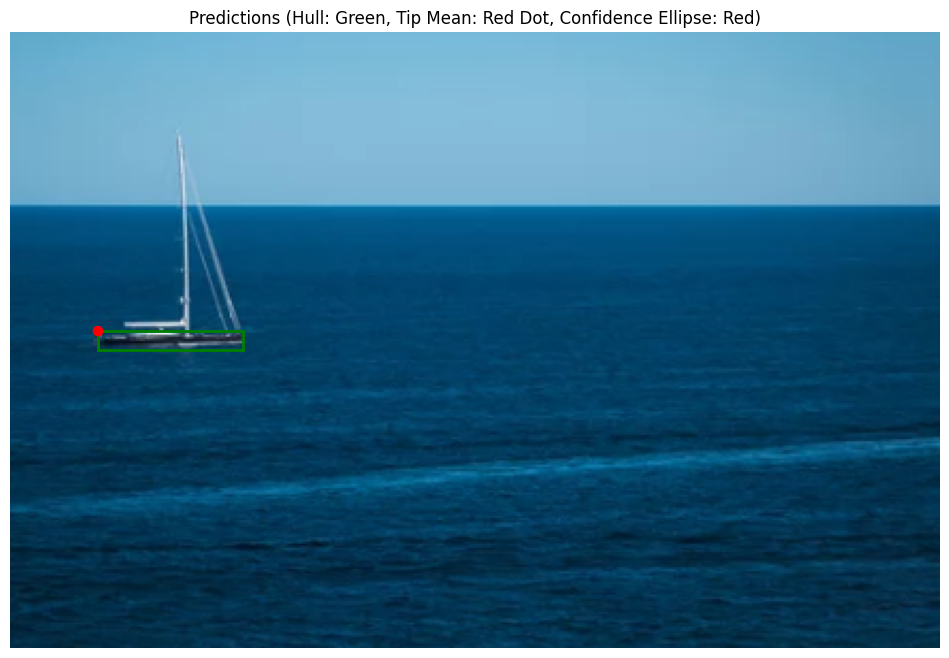

In [82]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import numpy as np
import os
from PIL import Image

# Helper function to draw a confidence ellipse
def plot_confidence_ellipse(mu, sigma, rho, ax, n_std=2.0, facecolor='none', edgecolor='red', **kwargs):
    """
    Plots an ellipse representing the covariance of a 2D Gaussian distribution.

    mu: mean (x, y)
    sigma: standard deviations (sigma_x, sigma_y)
    rho: correlation coefficient
    ax: matplotlib axes object
    n_std: number of standard deviations for the ellipse size
    """
    cov = np.array([[sigma[0]**2, rho * sigma[0] * sigma[1]],
                    [rho * sigma[0] * sigma[1], sigma[1]**2]])

    # Eigenvalues and eigenvectors of the covariance matrix
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, edgecolor=edgecolor, **kwargs)

    # Calculate the rotation angle of the ellipse
    theta = np.arctan2(cov[1, 0], cov[0, 0] - cov[1, 1]) / 2
    angle = np.degrees(theta) # in degrees

    # Scale the ellipse by the standard deviations
    scale_x = sigma[0] * n_std
    scale_y = sigma[1] * n_std

    trans = transforms.Affine2D().rotate_deg(angle).scale(scale_x, scale_y).translate(mu[0], mu[1])
    ellipse.set_transform(trans + ax.transData)
    return ax.add_patch(ellipse)

# --- Configuration ---
# Select an image to visualize (e.g., the first image from the training dataset)
if len(train_ds) > 0:
    test_image_path = train_ds.images[0]
    print(f"Visualizing: {test_image_path}")
else:
    print("No images available in train_ds for visualization.")
    test_image_path = None

# Whether to use YOLO for hull detection or the placeholder box
# Make sure USE_YOLO is defined in your environment (e.g., from cell DsHVts-EfFm1)
# USE_YOLO = True # Uncomment and set if not already defined globally

# --- Visualization Code ---
if test_image_path:
    # Get hulls (using YOLO if USE_YOLO is True, otherwise the placeholder)
    if USE_YOLO:
         # Make sure run_yolo_detect is defined (e.g., from cell S1eBN8N3b5x8)
        hulls = run_yolo_detect(test_image_path)
        if not hulls:
            print(f"No hulls detected by YOLO for {test_image_path}. Cannot perform Stage B inference.")
            hulls = [] # Ensure hulls is an empty list if no detections
    else:
        # Placeholder hull detection logic (from cell DsHVts-EfFm1)
        try:
            im_viz = Image.open(test_image_path).convert('RGB')
            W, H = im_viz.size
            w = int(0.5 * W)
            h = int(0.3 * H)
            x = int((W - w) / 2)
            y = int((H - h) / 2)
            hulls = [[x, y, w, h]]
            if w <= 0 or h <= 0:
                 print(f"Generated invalid hull box dimensions for {test_image_path}. Cannot perform Stage B inference.")
                 hulls = []
        except Exception as e:
             print(f"Error processing image {test_image_path}: {e}. Cannot perform Stage B inference.")
             hulls = []


    # Perform Stage B inference if hulls are available
    if hulls:
        # Make sure infer_stage_b is defined (e.g., from cell S1eBN8N3b5x8)
        # Make sure model and DEVICE are defined (e.g., from cell ywPq-ixXb7ph)
        # Make sure CONE_CFG is defined (e.g., from cell Pvvs_2ySbviS)
        preds = infer_stage_b(model, test_image_path, hulls, device=DEVICE, cone_cfg=CONE_CFG)

        # Load the original image for plotting
        img_orig = Image.open(test_image_path).convert('RGB')
        img_np = np.array(img_orig)

        # Create plot
        fig, ax = plt.subplots(1, figsize=(12, 8))
        ax.imshow(img_np)
        ax.set_title("Predictions (Hull: Green, Tip Mean: Red Dot, Confidence Ellipse: Red)")
        ax.axis('off')

        # Draw predictions
        for p in preds:
            # Draw hull box
            x, y, w, h = p['box_xywh']
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

            # Draw predicted tip mean (red dot)
            tip_x, tip_y = p['tip_xy']
            ax.plot(tip_x, tip_y, 'ro', markersize=5)

            # Draw confidence ellipse
            plot_confidence_ellipse(p['tip_xy'], p['sigma'], p['rho'], ax, n_std=2.0, edgecolor='red', linewidth=1.5)

        # Optional: Draw Ground Truth Tips for comparison
        # This requires accessing the ground truth labels
        try:
            # Assuming you have the label path and _parse_yolo_label function available
            # Need to get the original image size to scale YOLO labels
            original_img_w, original_img_h = Image.open(test_image_path).size
            base = os.path.splitext(os.path.basename(test_image_path))[0]
            # Assuming LABELS_DIR and TRAIN_LABELS_DIR are defined
            # Need to determine if this test image is from train, val, or test set
            # For simplicity, assuming it's from train for this example
            label_path_gt = os.path.join(TRAIN_LABELS_DIR, base + '.txt')

            if os.path.exists(label_path_gt):
                _, gt_tips = _parse_yolo_label(label_path_gt, original_img_w, original_img_h)
                if gt_tips:
                    print(f"Found {len(gt_tips)} ground truth tips.")
                    for gt_tip_x, gt_tip_y in gt_tips:
                         # Draw ground truth tip (e.g., as a blue cross)
                         ax.plot(gt_tip_x, gt_tip_y, 'bx', markersize=8, markeredgewidth=2, label='Ground Truth Tip')
                    # Add legend if ground truth tips are plotted
                    # handles, labels = ax.get_legend_handles_labels()
                    # unique_labels = dict(zip(labels, handles))
                    # ax.legend(unique_labels.values(), unique_labels.keys())

            else:
                 print(f"Ground truth label file not found for {test_image_path} at {label_path_gt}")
        except NameError:
             print("Could not visualize ground truth tips: required variables (e.g., TRAIN_LABELS_DIR, _parse_yolo_label) not defined in this scope.")
        except Exception as e:
            print(f"An error occurred while trying to visualize ground truth tips: {e}")


        plt.show()

    else:
        print("Skipping visualization as no hulls were detected or generated.")